# How can we control the increasing number of accidents in New York?

In [1]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

## Introduction

**Business Context.** The city of New York has seen a rise in the number of accidents on the roads in the city. They would like to know if the number of accidents have increased in the last few weeks. For all the reported accidents, they have collected details for each accident and have been maintaining records for the past year and a half (from January 2018 to August 2019). 

The city has contracted you to build visualizations that would help them identify patterns in accidents, which would help them take preventive actions to reduce the number of accidents in the future. They have certain parameters like borough, time of day, reason for accident, etc. Which they care about and which they would like to get specific information on.

**Business Problem.** Your task is to format the given data and provide visualizations that would answer the specific questions the client has, which are mentioned below.

**Analytical Context.** You are given a CSV file (stored in the already created ```data``` folder) containing details about each accident like date, time, location of the accident, reason for the accident, types of vehicles involved, injury and death count, etc. The delimiter in the given CSV file is `;` instead of the default `,`. You will be performing the following tasks on the data:

1. Extract additional borough data stored in a JSON file
2. Read, transform, and prepare data for visualization
3. Perform analytics and construct visualizations of the data to identify patterns in the dataset
        
The client has a specific set of questions they would like to get answers to. You will need to provide visualizations to accompany these:

1. How have the number of accidents fluctuated over the past year and a half? Have they increased over the time?
2. For any particular day, during which hours are accidents most likely to occur?
3. Are there more accidents on weekdays than weekends?
4. What are the accidents count-to-area ratio per borough? Which boroughs have disproportionately large numbers of accidents for their size?
5. For each borough, during which hours are accidents most likely to occur?
6. What are the top 5 causes of accidents in the city? 
7. What types of vehicles are most involved in accidents per borough?
8. What types of vehicles are most involved in deaths?

## Fetching the relevant data

The client has requested analysis of the accidents-to-area ratio for boroughs. Borough data is stored in a JSON file in the ```data``` folder.

### Question (5 min):

Use the function ```json.load()``` to load the file ```borough_data.json``` as a dictionary.

**Answer.** One possible solution is given below:

In [2]:
with open('data/borough_data.json') as f:
    borough_data=json.load(f)
    
borough_data

{'the bronx': {'name': 'the bronx', 'population': 1471160.0, 'area': 42.1},
 'brooklyn': {'name': 'brooklyn', 'population': 2648771.0, 'area': 70.82},
 'manhattan': {'name': 'manhattan', 'population': 1664727.0, 'area': 22.83},
 'queens': {'name': 'queens', 'population': 2358582.0, 'area': 108.53},
 'staten island': {'name': 'staten island',
  'population': 479458.0,
  'area': 58.37}}

### Question (5 min):

Similarly, use the pandas function ```read_csv()``` to load the file ```accidents.csv``` as a DataFrame. Name this DataFrame ```df```. 

**Answer.** One possible solution is given below:

In [3]:
with open('data/accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')

## Overview of the data

Let's go through the columns present in the dataframe:

In [4]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

We have the following columns

1. **BOROUGH**: The borough in which the accident occured
2. **COLLISION_ID**: A unique identifier for this collision
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Reasons for the accident
4. **CROSS STREET NAME**: Nearest cross street to the place of accidents
5. **DATE**: Date of the accident
6. **TIME**: Time of accident
7. **LATITUDE**: Latitude of the accident
8. **LONGITUDE**: Longitude of the accident
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Category wise injury
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) KILLED**: Category wise death
11. **ON STREET NAME**: Street where the accident occured
13. **VEHICLE TYPE CODE (1, 2, 3, 4, 5)**: Types of vehicles involved in the accident
14. **ZIP CODE**: zip code of the accident location

### Exercise 1 (30 min):

Since 2014, New York City has been implementing a road safety plan named [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/). It aims to reduce the number of traffic deaths to *zero* by the end of 2024. The plan is creating new and enhancing current safety measures, some of these include:

- [ ] Automated pedestrian detection
- [ ] Road safety audits at high risk locations
- [ ] Expansion in the cycle track network
- [ ] Targeted education and awareness initiatives
- [ ] Creation of pedestrian refuge islands
- [ ] Launch Integrated Data-Driven Speed Reducer Program (speed humps & speed cushions)

Which of these initiatives could directly benefit from an analysis of the data provided? Check all that apply.

**Note:** You can create check marks by double-clicking this cell and adding an ```[x]``` in the corresponding lines. 

**Answer.**

- [ ] Automated pedestrian detection

The data provided contains the exact location, the number of pedestrians injured/killed, and the contributing factor of the vehicles in each accident. We could study the accidents where pedestrians were injured or killed. This *could* help to place cameras at important spots, where the automatic detection may be needed. However, for the *implementation* of automated pedestrian detection, a data set of images of crosswalks and intersections is more crucial.

- [x] Road safety audits at high risk locations

As discussed, our data can help with the recognition of problematic spots. We can check the street names where a high number of accidents have occured in the past, then inspect the area to see what extra measures should be implemented. 

- [ ] Expansion in the cycle track network

Our data contains the number of cyclists injured/killed. We could determine the spots where these are happening the most and then improve the safety measures around the area. However, we would need more data to determine if these locations have a high volume of cyclists. Thus the data may not be that beneficial for making decisions on expanding the cycle network.

- [x] Targeted education and awareness initiatives

The data provides the contributing factor of the accidents along with the type of vehicles that were involved in them. We can then study which types of vehicles cause the most number of accidents and organize educational initiatives around this.

- [ ] Creation of pedestrian refuge islands

Pedestrian islands are usually created on streets that are very wide. Thus, the information provided might not be that beneficial for this initiative, as we do not have information on the width/size of streets.

- [x] Launch Integrated Data-Driven Speed Reducer Program (speed humps & speed cushions)

One of the contributing factors in accidents provided in the data is speeding. We can check if these accidents occur in highly transited areas. Thus, our data might be useful for the implementation of this initiative.

Let's go ahead and answer each of the client's questions.

## Answering the client's questions

### Exercise 2 (30 min):

Group the available data on a monthly basis and generate a line plot of accidents over time. Has the number of accidents increased over the past year and a half?

**Hint**: You may find the pandas functions ```to_datetime()``` and ```dt.to_period()``` useful.

**Answer.** One possible solution is given below:

<AxesSubplot:xlabel='DATE'>

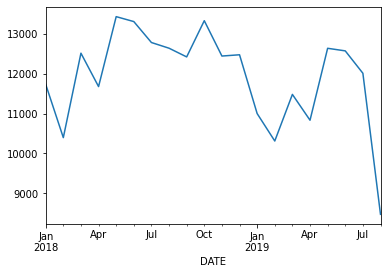

In [5]:
#First we need to change the format of the column DATE to datetime:
df['DATE']=pd.to_datetime(df['DATE'])

#Then, check whether the number of accidents has increased over time
monthly_accidents = df.groupby(df['DATE'].dt.to_period('M')).size()
monthly_accidents.plot.line()

The line graph we plotted clearly shows that there is no obvious uptrend in accidents over time.

### Exercise 3 (15 min):

From the plot above, which months seem to have the least number of accidents? What do you think are the reasons behind this?

**Answer.** Here is one possible solution.

We notice that August of 2019 is the month with the lowest number of accidents, but this is probably due to the fact that there is not a complete record for this month: ```max(df['DATE'])=Timestamp('2019-08-24 00:00:00')```. Namely, the entire final week of data is missing.

Disregarding this month, the lowest number of accidents appear to happen in February. This is the month of the year with the lowest temperatures and road conditions might get a little complicated. Thus, people may prefer to use public transportation and avoid going out as much as possible due to the cold weather. This is in contrast with summer, where people are prone to go out and more accidents may occur.   

### Exercise 4 (30 min):

How does the number of accidents vary throughout a single day? Create a new column `HOUR` based on the data from the `TIME` column, then plot a bar graph of the distribution per hour throughout the day.

**Hint:** You may find the function ```dt.hour``` useful. 

**Answer.** One possible solution is given below:

<AxesSubplot:xlabel='HOUR'>

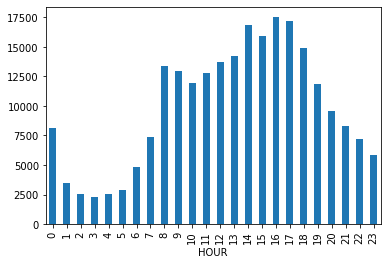

In [6]:
#Firt change the format of the TIME column
df['TIME']=pd.to_datetime(df['TIME'])

# Create a new hour column 
df['HOUR'] = df['TIME'].dt.hour

# Find out how the number of accidents varies across hours. 
hourly_accidents = df.groupby('HOUR').size()
hourly_accidents.plot.bar()

From this, we see that more accidents occur in the afternoon (2 - 6 PM) than at other times of day.

### Exercise 5 (15 min):

In the above question we have aggregated the number accidents per hour disregarding the date and place of ocurrence. Which criticism would you give to this approach?

**Answer.** Here is one possible solution.

Aggregating the data will be a problem if the disregarded variables exhibit large degrees of variation and are not distributed very evenly. It may be the case that the concetration of accidents in some zones of the city happen at different times of the day, yet by aggregating the data we may falsely conclude that accidents are constant in the entire city. Probably, residential zones are busy around 5 - 7pm, but commercial or manufaturing zones might be busy around 3 - 5pm. This information is important if the client is interested in designing a deployment plan for police officers to litigate traffic accidents, yet will be missed if we aggregate across all places of occurrence.

### Exercise 6 (15 min):

How does the number of accidents vary throughout a single week? Plot a bar graph based on the accidents count by day of the week.

**Hint:** You may find the function ```dt.weekday``` useful.

**Answer.** One possible solution is given below:

<AxesSubplot:xlabel='WEEKDAY'>

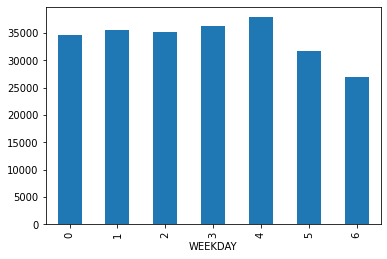

In [7]:
df['WEEKDAY'] = df['DATE'].dt.weekday
weekday_accidents = df.groupby('WEEKDAY').size()
weekday_accidents.plot.bar()

There are relatively fewer accidents on weekends than weekdays.

### Exercise 7 (30 min):

Plot a bar graph of the total number of accidents in each borough, as well as one of the accidents per square mile per borough. What can you conclude?

**Hint:** You may want to update some of the keys in the borough dictionary to match the names in the dataframe. 

**Answer.** One possible solution is given below:

<AxesSubplot:xlabel='BOROUGH'>

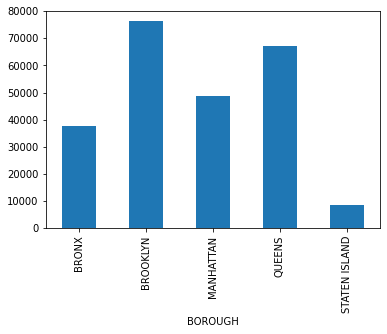

In [8]:
boroughs = df.groupby('BOROUGH').size()
boroughs.plot.bar()

We can see that Brooklyn and Queens have a very high number of accidents relative to the other three boroughs. But how about per square mile?

In [9]:
# Update keys in borough data
print(borough_data.keys())
print(df['BOROUGH'].unique())

# Since there are differences in the text used in the data and Wikipedia data, let's update it
borough_data['bronx'] = borough_data.pop('the bronx')

dict_keys(['the bronx', 'brooklyn', 'manhattan', 'queens', 'staten island'])
['BRONX' 'BROOKLYN' 'QUEENS' 'MANHATTAN' 'STATEN ISLAND']


We have now got the keys to match in the dictionary and the dataframe. The difference in case can be handled by making the mapping action case-insensitive. This can be done by either converting the dictionary keys to uppercase, or the dataframe data to lowercase.

Let's do that and plot `accidents_per_sq_mi`, which is the accidents-to-area ratio:

<AxesSubplot:xlabel='borough'>

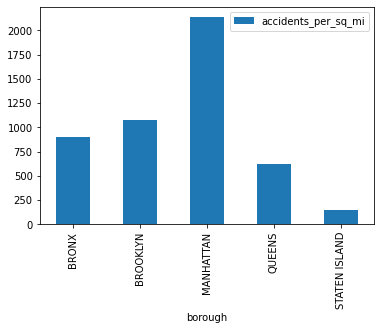

In [10]:
borough_frame = pd.DataFrame(boroughs)
borough_frame.columns = ['count']
borough_frame['borough'] = borough_frame.index

borough_frame['accidents_per_sq_mi'] = borough_frame.apply(lambda x: x['count'] / borough_data[x['borough'].lower()]['area'], axis=1)
borough_frame.plot.bar(x='borough', y='accidents_per_sq_mi')

When looking at the `accidents_per_sq_mi` parameter, Manhattan tops the list by a wide margin. This clearly shows that even though Brooklyn and Queens have more total accidents, Manhattan has a much higher concentration of accidents.

### Exercise 8 (30 min):

Which hours have the most accidents for each borough? Plot a bar graph for each borough showing the number of accidents for each hour of the day.

**Hint:** You can use ```sns.FacetGrid``` to create a grid of plots with the hourly data of each borough. 

**Answer.** One possible solution is given below:

/home/jovyan/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


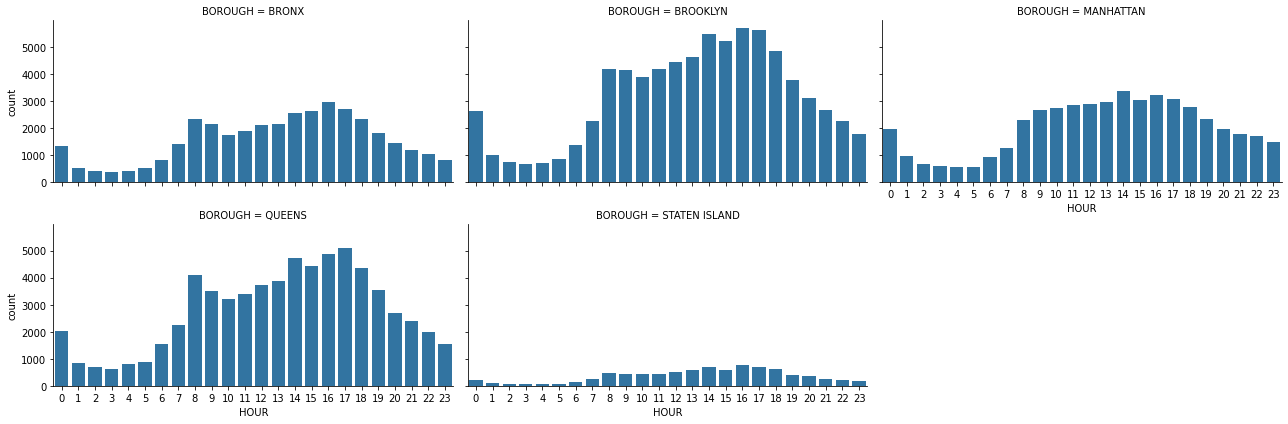

In [11]:
df1 = pd.DataFrame({'count': df.groupby(['BOROUGH', 'HOUR']).size()})
df1 = df1.reset_index()

chart = sns.FacetGrid(df1, col='BOROUGH', margin_titles=True, col_wrap=3, aspect=2, row_order=df['BOROUGH'].unique)
chart.map(sns.barplot, 'HOUR', 'count',)

**Is the number of accidents higher at different times in different boroughs? Should we concentrate at different times for each borough?**

We can see that in all the boroughs the accident count is highest from approximately 2 - 6PM. But in Manhattan and the Bronx, you can see that there is not as much of a relative increase during these hours as in Brooklyn or Queens. Additionally, Staten Island has the lowest overall number of accidents.

### Exercise 9 (45 min):

What factors cause the most accidents? Avoid double counting the contributing factors of a single accident. 

**Hint:** One way of dealing with repetitions is to concatenate the corresponding columns while preserving their indexes, you can do that with the functions ```pd.concat()``` and  ```reset_index()```. Then, use an appropiate ```group_by``` to count the number of repetitions of contributed factors per accident.   

**Answer**. Here we show two possible solutions. Notice how the first solution is more efficient than the second one. 

**Solution 1**

The first solution uses the hint provided in the question. 

In [12]:
columns = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 
           'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
          'CONTRIBUTING FACTOR VEHICLE 5']

#First, we concatenate all the corresponding columns into a big data-frame
frames=[df[column].reset_index().rename(columns={column:'FACTOR'}) for column in columns]
factors_df=pd.concat(frames)



#The reasoning behind doing reset_index() is that we can use a groupby on the indexes to delete repetitions as follows:
no_rep_factors=factors_df.groupby(['index','FACTOR']).size().reset_index()

#The data frame we are looking for is given by
final_df=no_rep_factors.groupby(['FACTOR']).size()

#Since we want to search for the most common factors of accidents, we can do the following:
final_df=final_df.sort_values(ascending=False).reset_index()
final_df.head(6)

,FACTOR,0
0,Unspecified,190096
1,Driver Inattention/Distraction,61752
2,Failure to Yield Right-of-Way,19641
3,Following Too Closely,17293
4,Backing Unsafely,14835
5,Passing Too Closely,12631


**Solution 2**

Since the data is present in multiple columns (`CONTRIBUTING FACTOR VEHICLE 1 - 5`) and repetitions may occur, let us first create a new column having unique factors per accident. After that, we count the number of appearances of each factor across the rows. 

In [13]:
df['unique factors'] =df.apply(lambda x: set([x[column] for column in columns if x[column]]), axis=1)
factors_count = {}
for index, row in df.iterrows():
    for factor in row['unique factors']:
        count = factors_count.get(factor, 0)
        count += 1
        factors_count[factor] = count
factor_count = sorted(factors_count.items(), key=lambda x: x[1], reverse=True)

In [14]:
factor_count[:10]

[(nan, 237730),
 ('Unspecified', 190096),
 ('Driver Inattention/Distraction', 61752),
 ('Failure to Yield Right-of-Way', 19641),
 ('Following Too Closely', 17293),
 ('Backing Unsafely', 14835),
 ('Passing Too Closely', 12631),
 ('Passing or Lane Usage Improper', 11808),
 ('Other Vehicular', 8860),
 ('Unsafe Lane Changing', 6643)]

The top 5 causes are:

1. Driver Inattention/Distraction
2. Failure to Yield Right-of-Way
3. Following Too Closely
4. Backing Unsafely 
5. Passing Too Close

### Exercise 10 (45 min):

Which vehicle types are most involved in accidents per borough? Avoid double counting the type of vehicles present in a single accident. 

**Hint:** You can apply a similar approach to the one used in the previous question.

**Answer.** 

In [15]:
columns = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
           'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',]

# Concatenate all corresponding frames.
frames=[df[['BOROUGH',column]].rename(columns={'BOROUGH':'BOROUGH',column:'VEHICLE'}) for column in columns]
vehicles_df=pd.concat(frames).reset_index()

#Count repetitions
no_rep_vehicles=vehicles_df.groupby(['index','BOROUGH','VEHICLE']).size().reset_index()

#Then get rid of these
final_df=no_rep_vehicles.groupby(['BOROUGH','VEHICLE']).size().sort_values(ascending=False).reset_index()

final_df.head(10)

,BOROUGH,VEHICLE,0
0,BROOKLYN,Sedan,39459
1,QUEENS,Sedan,35103
2,BROOKLYN,Station Wagon/Sport Utility Vehicle,32262
3,QUEENS,Station Wagon/Sport Utility Vehicle,31647
4,MANHATTAN,Sedan,20727
5,BRONX,Sedan,19652
6,MANHATTAN,Station Wagon/Sport Utility Vehicle,16432
7,BRONX,Station Wagon/Sport Utility Vehicle,15434
8,BROOKLYN,PASSENGER VEHICLE,10177
9,MANHATTAN,Taxi,8989


We can see that `Sedan` and `Station Wagon/Sport Utility Vehicle` are clear winners for causing the highest number of accidents, and that this does not differ across boroughs.

### Exercise 11 (15 min):

In a 2018 [interview](https://www.nytimes.com/2019/01/01/nyregion/traffic-deaths-decrease-nyc.html) with The New York Times, New York's mayor de Blasio stated that *'Vision Zero is clearly working'*. That year, the number of deaths in traffic accidents in NYC dropped to a historical 202. Yet, as reported by [am New York Metro](https://www.amny.com/news/vision-zero-de-blasio-1-30707464/), the number of fatalities has increased by 30% in the first quarter of 2019 compared to the previous year and the number of pedestrians and cyclist injured has not seen any improvement.

How would you use the provided data to understand what went wrong in the first quarter of 2019?

> - [ ] Consider the accidents of the first quarter of 2019. Then, check for the most common causes of accidents where pedestrians and cyclists were involved. Give a recommendation based solely on this information. 

> - [ ] Create a pair of heatmaps of the accidents involving injured/killed pedestrians and cyclists in the first quarter of 2018 and 2019. Compare these two to see if there is any change in the concentration of accidents. In critical areas, study the type of factors involved in the accidents. Give a recommendation to visit these areas to study the problem further.    

> - [ ] The provided data is insufficient to improve our understanding of the situation.

> - [ ] None of the above. I would do the following: *here your recommended answer*.

**Answer.** Here is one possible solution.

* The first answer is not viable as we are not taking into account possible changes the Vision Zero program implemented after the first quarter of 2018.

* The second answer is more nuanced as it is trying to understand first what changes might had happend after the first quarter of 2018. Then, it concetrates in important areas of the city and then suggests a visit to improve understanding of the situation. 

* The third answer is not correct. Even though the provided data may not completely answer what went wrong in the first quarter of 2019, it may provide hints of where to look and avoid unnecessary work.

* Your answer may also be valid. There is not always a single approach for the understanding of problems like this one.

### Exercise 12 (45 min):

Calculate the number of deaths caused by each type of vehicle. Plot a bar chart for the top 5 vehicles. Which vehicles are most often involved in deaths, and by how much more than the others?

**For example,** if two people died at an accident where 5 vehicles were involved: 4 are PASSENGER VEHICLE and 1 is a SPORT UTILITY/STATION WAGON. Then, we would add two deaths to each PASSENGER VEHICLE and SPORT UTILITY/STATION WAGON types.

**Hint:** You may want to create a new column with the total number of kills in the accident. For that you may find the function ```.to_numpy()``` useful. Then, proceed as the previous excercises to avoid double-counting the type of vehicles. 

**Answer.** One possible solution is given below:

In [16]:
columns = ['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
           'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',]

killed_columns=['NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED']

#Create a new column with the total of kills.
TOTAL=0
for column in killed_columns:
    TOTAL+=df[column].to_numpy()
df['TOTAL_KILLED']=pd.DataFrame(TOTAL)

#Get rid of the accidents with no deaths. This might increase efficiency in further computations.
deaths_df=df[columns+['TOTAL_KILLED']]
deaths_df=deaths_df[deaths_df['TOTAL_KILLED']>0]

#Next, we get rid of the repetitions of vehicles in a single accident
frames=[deaths_df[['TOTAL_KILLED',column]].rename(columns={column:'VEHICLE'}) for column in columns]
vehicles_df=pd.concat(frames).reset_index()
vehicles_norep_df=vehicles_df.groupby(['index','TOTAL_KILLED','VEHICLE']).size().reset_index()
vehicles_norep_df=vehicles_norep_df[['TOTAL_KILLED','VEHICLE']]

#Finally, we count the number of deaths
final_df=vehicles_norep_df.groupby('VEHICLE').sum().sort_values(['TOTAL_KILLED'], ascending=False).reset_index()
final_df.head(10)

,VEHICLE,TOTAL_KILLED
0,Station Wagon/Sport Utility Vehicle,87
1,Sedan,65
2,Motorcycle,22
3,PASSENGER VEHICLE,21
4,SPORT UTILITY / STATION WAGON,20
5,Bike,19
6,Bus,10
7,Box Truck,8
8,Pick-up Truck,8
9,Taxi,5


Notice that ```SPORT UTILITY / STATION WAGON``` is essentially the same as ```Station Wagon/Sport Utility Vehicle```. Later in the course we will see how to properly clean errors like this  in the data. For now, let us omit this fact and continue with the analysis. 

[Text(0, 0, 'Station Wagon/Sport Utility Vehicle'),
 Text(1, 0, 'Sedan'),
 Text(2, 0, 'Motorcycle'),
 Text(3, 0, 'PASSENGER VEHICLE'),
 Text(4, 0, 'SPORT UTILITY / STATION WAGON')]

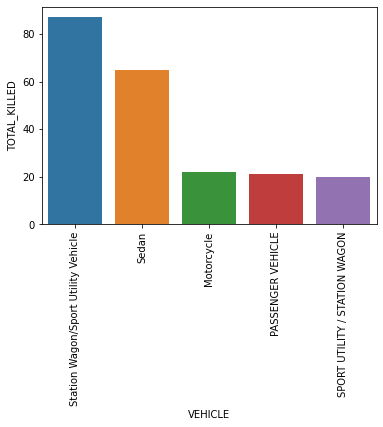

In [17]:
#Finally, we plot the data
barplot = sns.barplot(data=final_df[:5], x='VEHICLE', y='TOTAL_KILLED')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)

It appears that `Station Wagon/Sport Utility Vehicle` and `Sedan` cause the most deaths. The former causes 4 times as many deaths as the other vehicles, and the latter causes 3 times as many deaths as the other vehicles.